In [1]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"


import tensorflow as tf
import flowpm


import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from flowpm.kernels import fftk
import time

#some default values...
nc = 300

klin = np.loadtxt('../tardis-tf/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../tardis-tf/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)




In [2]:
!nvidia-smi

Tue Dec  1 03:36:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   33C    P8    10W / 250W |   1228MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   37C    P8    23W / 250W |   1260MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:


from flowpm.utils import white_noise, c2r3d, r2c3d, cic_paint, cic_readout
from flowpm.kernels import fftk, laplace_kernel, gradient_kernel, longrange_kernel



In [4]:
def c2r2d(cfield, norm=None, dtype=tf.float32, name=None):
  """
  Converts a complex Fourier domain field to a real field
  Parameters:
  -----------
  cfield: tensor (batch_size, nc, nc)
    Complex 2D real field
  norm: float
    Normalization factor
  dtype: tf.dtype
    Type of output tensor
  Return:
  -------
  rfield: tensor (batch_size, nc, nc)
    Real valued field
  """
  with tf.name_scope(name, "C2R2D", [cfield]):
    if norm is None: norm = tf.cast(tf.reduce_prod(cfield.get_shape()[1:]), dtype)
    else: norm = tf.cast(norm, dtype)
    rfield = tf.multiply(tf.cast(tf.signal.ifft2d(cfield), dtype), norm, name=name)
    return rfield


def r2c2d(rfield, norm=None, dtype=tf.complex64, name=None):
  """
  Converts a real field to its complex Fourier Transform
  Parameters:
  -----------
  rfield: tensor (batch_size, nc, nc)
    Input 2D real field
  norm: float
    Normalization factor
  dtype: tf.dtype
    Type of output tensor
  Return:
  -------
  cfield: tensor (batch_size, nc, nc)
    Complex field
  """
  with tf.name_scope(name, "R2C2D", [rfield]):
    if norm is None: norm = tf.cast(tf.reduce_prod(rfield.get_shape()[1:]), dtype)
    else: norm = tf.cast(norm, dtype)
    cfield = tf.multiply(tf.signal.fft2d(tf.cast(rfield, dtype)), 1/norm, name=name)
    return cfield

def white_noise_2d(nc, batch_size=1, seed=None, type='complex', name=None):
  """
  Samples a 2D cube of white noise of desired size
  """
  with tf.name_scope(name, "WhiteNoise"):
    assert batch_size >= 1
    white = tf.random_normal(shape=(batch_size, nc, nc),
                             mean=0, stddev=nc**1.5, seed=seed)
    if type == 'real': return white
    elif type == 'complex':
        whitec = r2c2d(white, norm=nc**2)
        return whitec


In [5]:
def linear_field_2d(nc, boxsize, pk, batch_size=1,
                 kvec=None, seed=None, name=None, dtype=tf.float32):
  """Generates a linear field with a given linear power spectrum
  Parameters:
  -----------
  nc: int
    Number of cells in the field
  boxsize: float
    Physical size of the cube, in Mpc/h TODO: confirm units
  pk: interpolator
    Power spectrum to use for the field
  kvec: array
    k_vector corresponding to the cube, optional
  Returns
  ------
  linfield: tensor (batch_size, nc, nc, nc)
    Realization of the linear field with requested power spectrum
  """
  with tf.name_scope(name, "LinearField"):
    if kvec is None:
      kvec = fftk((nc, nc), symmetric=False)
    kmesh = sum((kk / boxsize * nc)**2 for kk in kvec)**0.5
    pkmesh = pk(kmesh)

    whitec = white_noise_2d(nc, batch_size=batch_size, seed=seed, type='complex')
    lineark = tf.multiply(whitec, (pkmesh/boxsize**2)**0.5)
    linear = c2r2d(lineark, norm=nc**2, name=name, dtype=dtype)
    return linear,lineark

In [6]:


def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    #data = tf.squeeze(data)
    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

In [7]:



kvec = fftk((nc,nc), symmetric=False)
kmesh = sum((kk)**2 for kk in kvec)**0.5
print(len(kvec))
x_op = gradient_kernel(kvec,0,order=1)
y_op = gradient_kernel(kvec,1,order=1)


2


In [8]:
ic,ick = linear_field_2d(nc,nc,ipklin)

#smooth field

smwts = tf.exp(tf.multiply(-kmesh**2, 01.00))

#ick = r2c2d(ic)

ick_sm = tf.multiply(ick, tf.cast(smwts, tf.complex64))
smwts = tf.exp(tf.multiply(-kmesh**2, 00.010))

ic_sm = c2r2d(ick_sm)

dx = tf.multiply(ick_sm[0], x_op)
dy = tf.multiply(ick_sm[0], y_op)

dx2 = tf.multiply(dx, x_op)
dy2 = tf.multiply(dy, y_op)

dxdy = tf.multiply(dx, y_op)

g1_c = -2.0 * dxdy

g2_c = dx2-dy2

g1 = c2r2d(g1_c)
g2 = c2r2d(g2_c)

In [9]:
with tf.Session() as sess:
            linear_true,linear_truek,g1_true,g2_true= sess.run((ic,ic_sm,g1,g2))
        
        

Populating the interactive namespace from numpy and matplotlib


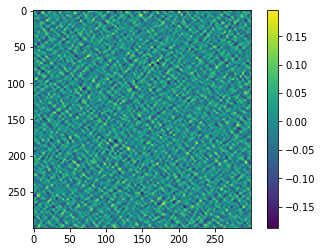

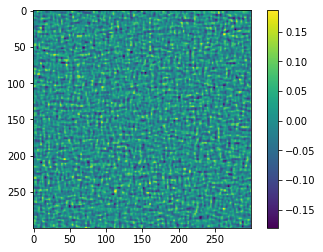

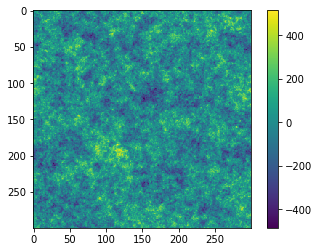

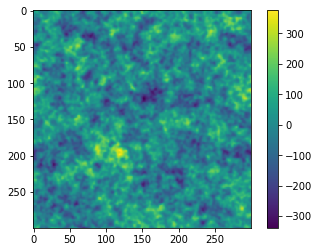

In [10]:
%pylab inline
imshow(g1_true)
colorbar()
show()

imshow(g2_true)
colorbar()
show()


imshow(linear_true[0])
colorbar()
show()



imshow(linear_truek[0])
colorbar()
show()

In [11]:
data = [g1_true+np.random.randn(nc,nc)*0.02,g2_true+np.random.randn(nc,nc)*0.02]



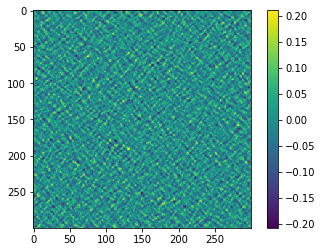

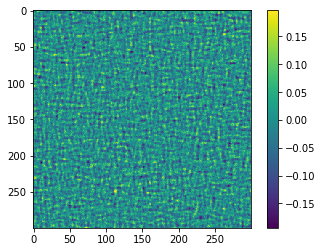

In [12]:
imshow(data[0])
colorbar()
show()

imshow(data[1])
colorbar()
show()

In [13]:
mask = np.ones((300,300))

mask[100:200,100:200] = 0.0

In [14]:
data[0] *= mask
data[1] *= mask

In [15]:
from scipy import ndimage

In [16]:
ic,ick = linear_field_2d(nc,nc,ipklin)



#initial field info
xx = tf.Variable(ndimage.gaussian_filter(np.random.randn(1,nc,nc)*100,1.0), name="redshift", trainable=True) #Starting Point
#ic2 = tf.get_variable('linmesh_op', shape=(1, nc, nc),
#                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
#initlin_op = ic2.assign(xx, name='initlin_op')
        
ick = r2c2d(xx)
#smooth field by very small kernel for numerical reasons
smwts = tf.exp(tf.multiply(-kmesh**2, 00.10))

#ick = r2c2d(ic)

ick_sm = tf.multiply(ick, tf.cast(smwts, tf.complex64))

ic_sm = c2r2d(ick_sm)

dx = tf.multiply(ick_sm[0], x_op)
dy = tf.multiply(ick_sm[0], y_op)

dx2 = tf.multiply(dx, x_op)
dy2 = tf.multiply(dy, y_op)

dxdy = tf.multiply(dx, y_op)

g1_c = -2.0 * dxdy

g2_c = dx2-dy2

g1 = c2r2d(g1_c)
g2 = c2r2d(g2_c)

#prior


lineark = r2c2d(ic, norm=nc**2)
priormesh = tf.square(tf.cast(tf.abs(ick), tf.float32))

pkmesh = ipklin(kmesh)
prior_1 = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**4



likelihood = tf.reduce_sum((mask*(g1-data[0])**2.0 + mask*(g2-data[1])**2.0))/(0.02)**2 + prior_1



/home/ben.horowitz/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [17]:
from tensorflow.contrib.opt import ScipyOptimizerInterface


In [18]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#########
# Initialize gradient descent at random point
#sess.run(self.initlin_op, {self.xx:starting_point, self.yy_gal:self.gal.samples_n[:,:2].reshape(1,self.gal.num_gal,2),self.yy_lya:self.lya.vals_observed,self.Rs:[0.0]});
        
start_time = time.time()
 
opt = ScipyOptimizerInterface(likelihood, var_list=[xx], method='L-BFGS-B',options={'maxiter': 1000, 'gtol':1e-5/10000000000})



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
z = opt.minimize(sess)


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 121871.234375
  Number of iterations: 1000
  Number of functions evaluations: 1128


In [20]:
state_recp,g1_recp,g2_recp = sess.run([ic_sm,g1,g2])

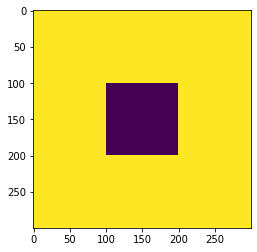

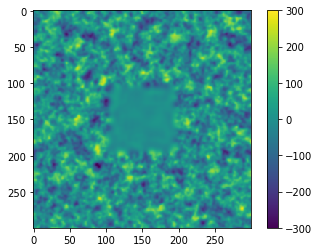

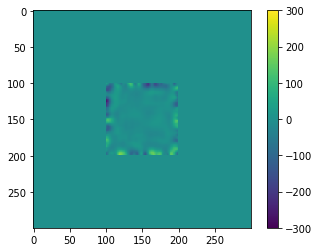

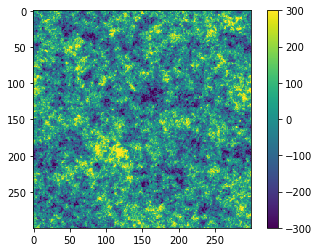

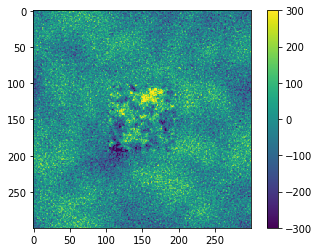

In [21]:
imshow(mask)
show()

imshow(state_recp[0],vmin=-300,vmax=300)
colorbar()
show()

imshow(state_recp[0]*(1-mask),vmin=-300,vmax=300)
colorbar()
show()

imshow(linear_true[0],vmin=-300,vmax=300)
colorbar()
show()

imshow(state_recp[0]-linear_true[0],vmin=-300,vmax=300)
colorbar()
show()